In [1]:
!./model.sh

 Model name: model.d
 LAYER             H      P-VEL     S-VEL   DENSITY  
     1      0.1000      1.500      0.000      1.000    
     2      0.2000E-01  1.600     0.4500E-01  1.500    
     3      0.2000E-01  1.250     0.1000      1.500    
     4       0.000      1.600      4.300      1.500    
 Model name: model.d
 LAYER             H      P-VEL     S-VEL   DENSITY  
     1      0.1000      1.500      0.000      1.000    
     2      0.2000E-01  1.600     0.4500E-01  1.500    
     3      0.2000E-01  1.250     0.1000      1.500    
     4       0.000      1.600      4.300      1.500    
 Searching for    4.08375300E-02  <= c <=    4.30000019    
 cmin,cmax   4.08375300E-02   4.30000019    
 Rayleigh Computations
  Number of layers=           4  Maximum modes=           1
  NPTS=          14  DT=  -1.00000000      CMIN=   4.08375300E-02  nfval=          14
  
 Total period=          14
  
 Number of modes at the lowest period:  0.71428572644992772       =            1
  
 Model:
 0.

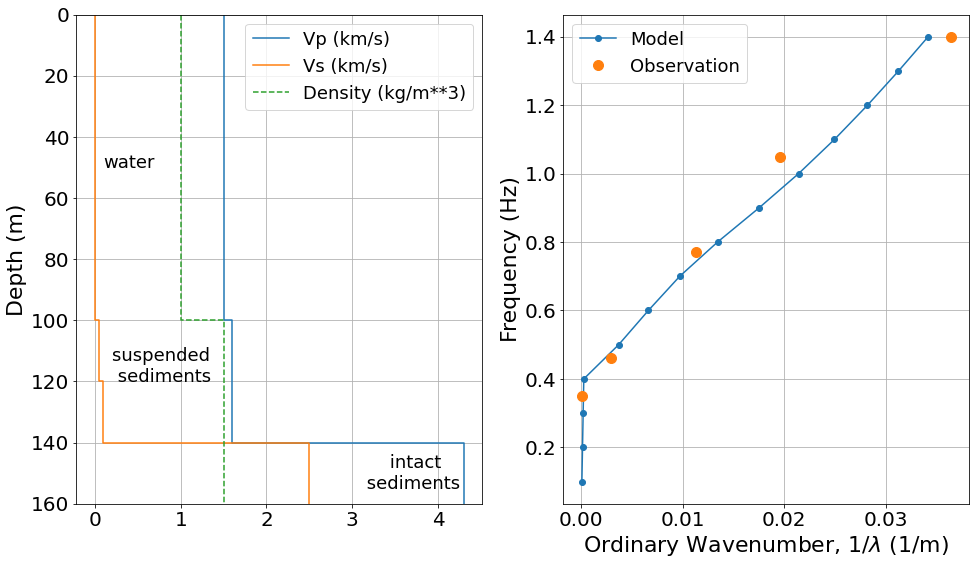

In [2]:
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data=pd.read_fwf('SDISPR.TXT',header=1,colspecs=[(22,34),(38,52)])
f = data['FREQ']
k = data['FREQ']/data['PHASE VEL']/1e3

kobs = np.array([0.0364, 0.0196, 0.0113, 0.0029, 0.0001])
fobs = np.array([1.4, 1.05, 0.77, 0.46, 0.35])
cobs = fobs/kobs

z = np.array([0.0, 0.1,  0.12, 0.14, 0.16]) * 1e3
p = np.array([1.5, 1.6,   1.6,  4.3,  4.3])
s = np.array([0, 0.045,   0.1,  2.5,  2.5])
rho=np.array([1,   1.5,   1.5,  1.5, 1.5])

fig,ax=plt.subplots(1,2,figsize=(16,9))
fig.patch.set_facecolor('w')
plt.subplot(121)
plt.step(p,z,label='Vp (km/s)')
plt.step(s,z,label='Vs (km/s)')
plt.step(rho,z,'--',label='Density (kg/m**3)')
plt.ylim([max(z),0])
plt.grid()
plt.legend(fontsize=18)
plt.ylabel('Depth (m)',fontsize=22)
plt.text(0.1,50,'water',fontsize=18)
plt.text(0.2,120,'suspended \n sediments',fontsize=18)
plt.text(3.1,155,'     intact \n sediments',fontsize=18)

plt.subplot(122)
plt.plot(k,f,'-o',label='Model')
plt.plot( kobs , fobs, 'o' , label='Observation',markersize=10)
plt.ylabel('Frequency (Hz)',fontsize=22)
plt.xlabel(r'Ordinary Wavenumber, $1/\lambda$ (1/m)',fontsize=22)
plt.legend(fontsize=18)

plt.grid()
plt.show()

In [3]:
for i in range(len(cobs)):
    print(f"2 1 0 {np.round(1/fobs[i],2)} {np.round(cobs[i])/1e3} 1.0")

2 1 0 0.71 0.038 1.0
2 1 0 0.95 0.054 1.0
2 1 0 1.3 0.068 1.0
2 1 0 2.17 0.159 1.0
2 1 0 2.86 3.5 1.0


In [4]:
1/kobs

array([   27.47252747,    51.02040816,    88.49557522,   344.82758621,
       10000.        ])

In [5]:
vp = p/1e3
rho = (1.6612 * vp - 0.4721 * vp**2 + 0.0671 * vp**3 - 0.0043 * vp**4 + 0.000106 * vp**5)*1000

In [6]:
rho

array([2.490738 , 2.6567117, 2.6567117, 7.1344362, 7.1344362])

In [7]:
p

array([1.5, 1.6, 1.6, 4.3, 4.3])